In [215]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
import matplotlib.gridspec as gridspec
%matplotlib inline
from cs231n.classifiers.vgg16_feature import Vgg16
from cs231n.image_utils import load_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


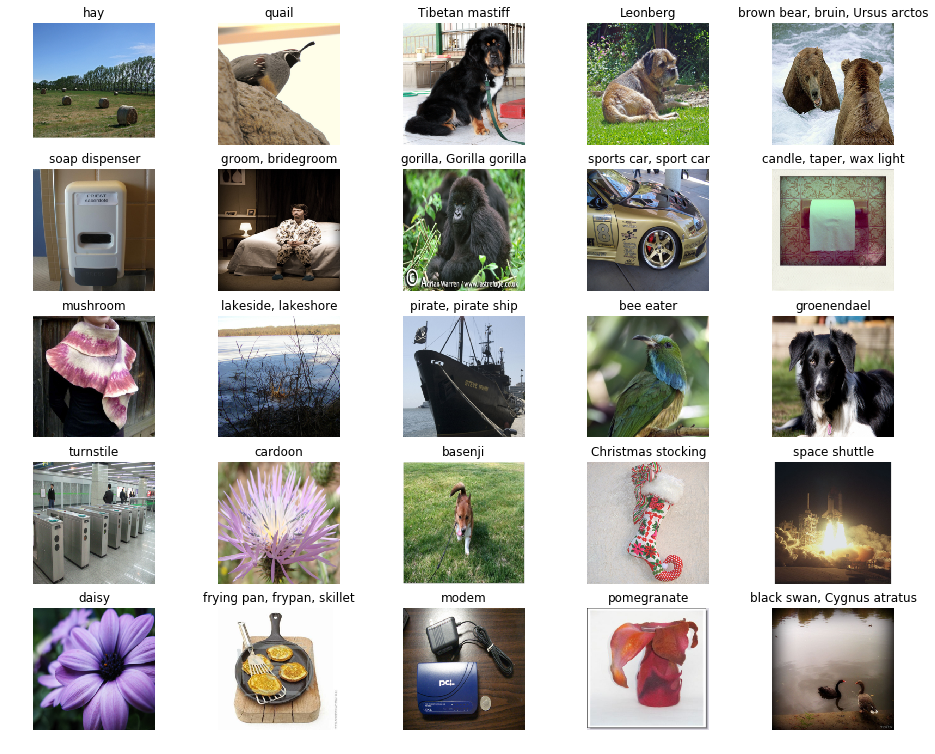

In [54]:
# when use vgg16 then this
with tf.InteractiveSession() as sess :
    prob = sess.run(vgg16net.prob, feed_dict = {images: X_raw})
    y_predict = tf.argmax(prob, axis = 1)

    for i in range(25):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        plt.imshow(X_raw[i])
        plt.title(class_names[sess.run(y_predict[i])])


In [216]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: scalar constant we multiply the content_loss by.
    - content_current: features of the current image, Tensor with shape [1, height, width, channels]
    - content_target: features of the content image, Tensor with shape [1, height, width, channels]
    
    Returns:
    - scalar content loss
    """
    return tf.reduce_sum(tf.square(content_current-content_original))*content_weight

def gram_matrix(features, normalize=True):
    """    
    Inputs:
    - features: Tensor of shape (1, H, W, C) giving features for
      a single image.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: Tensor of shape (C, C) giving the (optionally normalized)
      Gram matrices for the input image.
    """
    C = int(features.shape[3])
    F = tf.reshape(features, [-1, C])
    gram = tf.matmul(tf.transpose(F),F)
    
    if normalize is True :
        gram /= tf.cast(tf.size(features), dtype = tf.float32)
    return gram

def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a Tensor giving the Gram matrix the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A Tensor contataining the scalar style loss.
    """
    style_loss = 0
    
    for i, layer in enumerate(style_layers):
        style_loss += style_weights[i]*tf.reduce_sum(tf.square(gram_matrix(feats[layer]) - style_targets[i]))
    
    return style_loss

def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: Tensor of shape (1, H, W, 3) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: Tensor holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    # Your implementation should be vectorized and not require any loops!
    loss = 0
    loss = tf.reduce_sum(tf.square(tf.pad(img, paddings = [[0,0],[0,0],[1,0],[0,0]])\
                            -tf.pad(img, paddings = [[0,0],[0,0],[0,1],[0,0]]))[:,:,1:-1,:])
    loss += tf.reduce_sum(tf.square(tf.pad(img, paddings = [[0,0],[1,0],[0,0],[0,0]])\
                            -tf.pad(img, paddings = [[0,0],[0,1],[0,0],[0,0]]))[:,1:-1,:,:])
                 
    return tv_weight*loss

In [217]:
def deprocess_image(img, rescale=False):
    """Undo preprocessing on an image and convert back to uint8."""
    if rescale:
        vmin, vmax = img.min(), img.max()
        img = (img - vmin) / (vmax - vmin)
    return np.clip(255 * img, 0.0, 255.0).astype(np.uint8)

In [218]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

model = Vgg16(r'C:\Users\LG\Documents\CNN\assignment3\cs231n\datasets\vgg16.npy')
images = tf.placeholder(shape = [None,None,None,3], dtype = tf.float32)
model.build(images)

model_gen = Vgg16(r'C:\Users\LG\Documents\CNN\assignment3\cs231n\datasets\vgg16.npy')


npy file loaded
build model started
build model finished: 0s
npy file loaded


In [219]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    # Extract features from the content image
    content_img = load_image(content_image, size=image_size).astype(np.float32)/255.0
    
    content_target = sess.run(model.layers[content_layer],
                              {images: content_img[None]})

    # Extract features from the style image
    style_img = load_image(style_image, size=style_size).astype(np.float32)/255.0
    style_feat_vars = [model.layers[idx] for idx in style_layers]
    style_target_vars = []
    
    # Compute list of TensorFlow Gram matrices
    for style_feat_var in style_feat_vars:
        style_target_vars.append(gram_matrix(style_feat_var))
        
    # Compute list of NumPy Gram matrices by evaluating the TensorFlow graph on the style image
    style_targets = sess.run(style_target_vars, {images: style_img[None]})

    # Initialize generated image to content image
    if init_random:
        img_var = tf.Variable(tf.random_uniform(content_img[None].shape, 0, 1), name="image")
    else:
        img_var = tf.Variable(content_img[None], name="image")

    # Extract features on generated image
    model_gen.build(img_var)
    layers = model_gen.layers
    
    # Compute loss
    c_loss = content_loss(content_weight, layers[content_layer], content_target)
    s_loss = style_loss(layers, style_layers, style_targets, style_weights)
    t_loss = tv_loss(img_var, tv_weight)
    loss = c_loss + s_loss + t_loss
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180
    max_iter = 200

    # Create and initialize the Adam optimizer
    lr_var = tf.Variable(initial_lr, name="lr")
    # Create train_op that updates the generated image when run
    with tf.variable_scope("optimizer") as opt_scope:
        train_op = tf.train.AdamOptimizer(lr_var).minimize(loss, var_list=[img_var])
    # Initialize the generated image and optimization variables
    opt_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=opt_scope.name)
    sess.run(tf.variables_initializer([lr_var, img_var] + opt_vars))
    # Create an op that will clamp the image values when run
    clamp_image_op = tf.assign(img_var, tf.clip_by_value(img_var, -1.5, 1.5))
    
    f, axarr = plt.subplots(1,2)     # GOOD!!!
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess_image(content_img))
    axarr[1].imshow(deprocess_image(style_img))
    plt.show()
    plt.figure()
    
    # Hardcoded handcrafted 
    for t in range(max_iter):
        # Take an optimization step to update img_var
        sess.run(train_op)
        if t < decay_lr_at:
            sess.run(clamp_image_op)
        if t == decay_lr_at:
            sess.run(tf.assign(lr_var, decayed_lr))
        if t % 100 == 0:
            print('Iteration {}'.format(t))
            img = sess.run(img_var)
            plt.imshow(deprocess_image(img[0], rescale=True))
            plt.gca().set_axis_off()
            plt.show()
    print('Iteration {}'.format(t))
    img = sess.run(img_var)        
    plt.imshow(deprocess_image(img[0], rescale=True))
    plt.gca().set_axis_off()
    plt.show()

build model started
build model finished: 0s


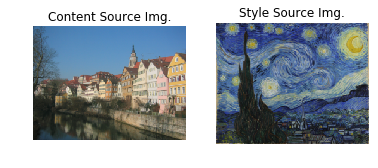

Iteration 0


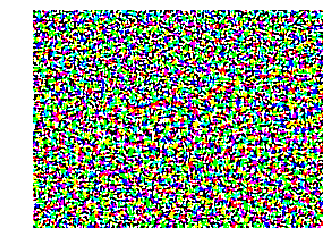

Iteration 100


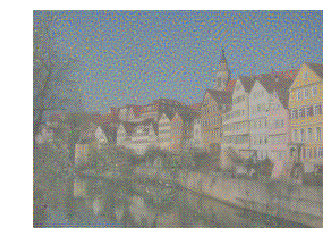

Iteration 199


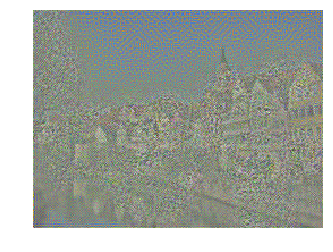

In [220]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True # we want to initialize our image to be random
}

style_transfer(**params_inv)

In [134]:
# in function you can make variable
def f(a): 
    b = tf.Variable(1, dtype = tf.float32, name = "bet")
    print(b)
    return a+b

In [137]:
tf.reset_default_graph()
c = f(2)
b = tf.get_default_graph().get_tensor_by_name("bet:0")

sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(b)

<tf.Variable 'bet:0' shape=() dtype=float32_ref>


1.0

In [152]:
# tensorflow is global!!
n = tf.constant(2)
def g():
    return n

In [153]:
g()

<tf.Tensor 'Const_3:0' shape=() dtype=int32>

In [223]:
import scipy.io

data = scipy.io.loadmat(r"C:\Users\LG\Documents\CNN\assignment3\cs231n\datasets\imagenet-vgg-verydeep-19.mat")

In [224]:
data

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat Sep 19 12:27:40 2015',
 '__version__': '1.0',
 'classes': array([[ (array([[array(['n01440764'],
       dtype='<U9'),
         array(['n01443537'],
       dtype='<U9'),
         array(['n01484850'],
       dtype='<U9'),
         array(['n01491361'],
       dtype='<U9'),
         array(['n01494475'],
       dtype='<U9'),
         array(['n01496331'],
       dtype='<U9'),
         array(['n01498041'],
       dtype='<U9'),
         array(['n01514668'],
       dtype='<U9'),
         array(['n01514859'],
       dtype='<U9'),
         array(['n01518878'],
       dtype='<U9'),
         array(['n01530575'],
       dtype='<U9'),
         array(['n01531178'],
       dtype='<U9'),
         array(['n01532829'],
       dtype='<U9'),
         array(['n01534433'],
       dtype='<U9'),
         array(['n01537544'],
       dtype='<U9'),
         array(['n01558993'],
       dtype='<U9'),
         array(['n01560419'

In [250]:
g = tf.Graph()
with g.as_default(), tf.Session() as sess:
    a = tf.constant(1)
    assert a.graph == g
    print(a.eval())

1


In [235]:
import sys

if 1 !=2 :
    raise ValueError("숫자가 다르다")

ValueError: 숫자가 다르다

In [257]:
a = tf.Variable(np.array([1,2]), dtype = tf.float32)
a.get_shape()[0].value

2

In [259]:
if not None :
    print(a)

<tf.Variable 'Variable_6:0' shape=(2,) dtype=float32_ref>
